In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import pandas as pd
# Pour torch si vous avez un GPU
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU

In [2]:
from environnement.environnement import Environnement as env # mother class
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from environnement.gridWorldMoreFB import gridWorldMoreFB

# model machine learning
from model.Tokenizer import *
from model.RNN import *
from model.CustomDataSet import CustomDataSet, CustomDataSetRNN
from outil import *
from inter.simpleInteraction import simpleInteraction as inter

# L'agent :

In [3]:
class AgentLSTM:
    def __init__(self, valence:dict[inter], model:nn.Module, maxDepth:int,
                seuil:float, optimizer, loss_fn, gap:int=11, nb_epochs:int=50,
                explo:int=3, data_val:tuple=None, device="cpu"):
        """
        Create an agent with a LSTM model and spesific decision making.
        data_val is composed by list of all actions and outcomes. And 
        is not useful to train the model. It's just to have a monitoring
        of the model. \n
        valence: dict of interactions, is use to know what is a good 
        comportment \n
        model: the model to train, this agent was create for LSTM model 
        \n
        
        """
        self.model:nn.Module = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.valence:dict[inter] = valence
        self.maxDepth:int = maxDepth
        self.seuil:float = seuil
        self.gap:int = gap
        self.nbEpochs:int = nb_epochs
        self.force_fit:bool = False
        self.device = device
        self.last_train = 0
        self.proba = 0
        self.explo = explo
        
        self.seq_to_exe = [] # Sequence choice by Decide
        self.seq_exe = []
        self.compute_seq = {}
        self.history_act = [] # History of all actions
        self.history_fb = [] # History of all feedback
        self.history_inter = [] # History of all interactions
        
        self.all_outcomes = set()
        self.all_act = set()
        key:inter = None
        for key in valence.keys():
            self.all_outcomes.add(key.getOutcome())
            self.all_act.add(key.getAction())
            
        self.all_outcomes = list(self.all_outcomes)
        self.all_act = list(self.all_act)
        
        self.tokenizer = SimpleTokenizerV1(
            vocab={key: i for i, key in enumerate(self.all_outcomes + self.all_act)})
        
        self.seq_explo = []
        self.valence_explo = -np.inf
        
        self.action_choice = self.all_act[0] # Default action, because developpemental start with action
        self.history_act.append(self.action_choice)
        self.outcome_prediction = None
        
        self.memory = {}
        
        # Variable to monitor the model
        self.loss_train:list = []
        self.acc_train:list = []
        self.loss_test:list = [0]
        self.acc_test:list = []
        self.time_train:list = []
        self.time_expected_val:list = []
        self.time_train:list = []
        self.time_expected_val:list = []
        self.predictExplor:list = []
        if data_val is not None:
            dataset_test = CustomDataSetRNN(actions=data_val[0], outcomes=data_val[1], context_lenght=self.gap, 
                                    dim_out=len(self.all_outcomes), tokenizer=self.tokenizer)
            self.data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
        else:
            self.data_loader_test = None
        number_patern = 2000000
        self.prealloc_df = pd.DataFrame(np.empty((number_patern, 5)), 
                                    columns=["proposition", "valence", "action", "probability", "val_sucess"])
        self.prealloc_df = self.prealloc_df.astype({"proposition": "U20", "valence": float, "action": "U20", "probability": float, "val_sucess": float})
        
        self.current_index = 0
        self.visu_explo = pd.DataFrame(np.empty((number_patern, 2)), columns=["seqence", "valence"])
        self.visu_explo = self.visu_explo.astype({"seqence": "U20", "valence": float})
        self.current_index_explo = 0
        
        if data_val is not None:
            self.visu_val = pd.DataFrame(np.empty((len(data_val[0]), 3)), 
                                        columns=["seqence", "probablility", "good"])
            self.visu_val = self.visu_val.astype({"seqence": "U20", "probablility": float, "good": bool})
            self.current_index_val = 0
        
    def fit(self):
        """
        train model
        """
        dataset = CustomDataSetRNN(actions=self.history_act, outcomes=self.history_fb, 
                                 context_lenght=self.gap, dim_out=len(self.all_outcomes),
                                 tokenizer=self.tokenizer)
        
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

        time_train = time.time()
        
        for i in range(self.nbEpochs):
            self.model.train()
            steps = 0
            train_acc = 0
            training_loss = []
            for tmp, (x,t) in enumerate(data_loader):
                x = x.to(self.device)
                t = t.to(self.device)
                bs = t.shape[0]
                h = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)
                cell = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)

                pred, h, cell = self.model(x, h, cell)

                loss = self.loss_fn(pred[:, -1, :], t)
                training_loss.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_acc += sum((pred[:, -1, :].argmax(1) == t).cpu().numpy())
                steps += bs
            
            self.acc_train.append(train_acc / steps)
            if self.data_loader_test is not None:
                self.model.eval()
                steps = 0
                test_acc = 0
                loss_test = []
                
                for text, label in self.data_loader_test:
                    text = text.to(self.device)
                    label = label.to(self.device)
                    bs = label.shape[0]

                    # Initialize hidden and memory states
                    hidden = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)
                    memory = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)
                    
                    # Forward pass through the model
                    pred, hidden, memory = self.model(text, hidden, memory)
                    
                    for i in range(bs):
                        self.visu_val.iloc[steps + i] = [str(self.tokenizer.decode(text[i].cpu().tolist())), 
                                                         float(torch.nn.functional.softmax(pred[i, -1, :], dim=-1).max().item()), 
                                                         int(pred[i, -1, :].argmax().item() == label[i])]

                    # Calculate the loss
                    loss = self.loss_fn(pred[:, -1, :], label)
                    loss_test.append(loss.item())

                    # Calculate test accuracy
                    test_acc +=  sum((pred[:, -1, :].argmax(1) == label).cpu().numpy())
                    steps += bs
                    
                loss_test.append(loss_test)
                self.acc_test.append(test_acc / steps)
                # print(f"Validation time: {time.time() - time_val_epoch}")    
            self.loss_train.append(training_loss)
            # If acc is 100% we stop the training
            if self.acc_train[-1] >= 0.99:
                for _ in range(i, self.nbEpochs):
                    self.acc_train.append(self.acc_train[-1])
                    if self.data_loader_test is not None:
                        self.loss_test.append(self.loss_test[-1])
                break
            
        # print(f"Training time: {time.time() - time_train}")
        self.time_train.append(time.time() - time_train)
        
    def predict(self, action):
        """
        Predict the feedback of the action, use the last gap actions/outcomes
        """        
        x = []
        for i in range(-(self.gap - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        x.append(action)
        seq_to_pred = self.tokenizer.encode(x)
        # On simule un batch de taille 1
        seq_to_pred = torch.tensor([seq_to_pred], device=self.device)
        h = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=self.device)
        cell = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=self.device)
        probs, _, _ = self.model(seq_to_pred, h, cell)
        
        pred_feedback = torch.argmax(probs[:, -1, :]).item()
        pred_feedback = self.tokenizer.decode(pred_feedback)
        
        return pred_feedback      
            
    def verify_explo(self, seq_to_pred, action, max_depth:int, previous_proba:float):
        sub_list = subfinder(self.history_inter, seq_to_pred[-self.explo:])        
        dict_explo = None
        if sub_list == []:
            inter_with_act = [inter(action, out) for out in self.all_outcomes]
            best_inter_act = None
            tmp_valence = -np.inf
            for tmp_inter in inter_with_act:
                if self.valence[tmp_inter] > tmp_valence:
                    best_inter_act = tmp_inter
                    tmp_valence = self.valence[tmp_inter]
            proba = []
            dict_explo = {
                "action" : action,
                "expected_valence" : tmp_valence,
                "outcome" : {"proba": None},
            }
            for out in self.all_outcomes:
                if out == best_inter_act.getOutcome():
                    proba.append((1, out))
                    if max_depth > 0:
                        new_context = seq_to_pred + self.tokenizer.encode([action, out])
                        children = self.recursif_expective_valance(context=new_context[2:], 
                                                                    max_depth=max_depth, 
                                                                    seuil=self.seuil,
                                                                    previous_proba=previous_proba)
                    
                        best_child = max(children, key=lambda x: x["expected_valence"])
                        dict_explo["outcome"] [out] =  best_child
                        dict_explo["expected_valence"] += best_child["expected_valence"]
                    else:
                        dict_explo["outcome"] [out] = {}
                else:
                    proba.append((-1, out))
                    dict_explo["outcome"] [out] = {}
                    
            dict_explo["outcome"] ["proba"] = proba
            
        return dict_explo
    
    def recursif_expective_valance(self, context:list, max_depth:int, seuil:float=0.5, previous_proba:float = 1):
        """
        Create the list of proposed sequences
        """
        max_depth -= 1
        self.model.eval()
        # Compute the expected valence of each action
        list_action = []
        for act in self.all_act:
            dict_seq = {
                    "action" : act,
                    "expected_valence" :0,
                }
            seq_to_predict = context + [self.tokenizer.encode(act)]
            explo = self.verify_explo(seq_to_predict, act, max_depth, previous_proba)
            if explo is not None:
                list_action.append(explo)
                continue
            
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.int).to(device)
            hidden = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
            memory = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
            x, _, _ = self.model(seq_to_predict, hidden, memory)
            x = x[0, -1, :]
            probs = torch.nn.functional.softmax(x, dim=0).tolist()
            proba = []
            dict_seq["outcome"] = {}
            for i, out in enumerate(self.all_outcomes):
                tmp_proba = probs[i] * previous_proba
                proba.append((probs[i], out))
                
                if tmp_proba > seuil:
                    if max_depth > 0:
                        new_context = context + self.tokenizer.encode([act, out])
                        children = self.recursif_expective_valance(context=new_context[2:], 
                                                                   max_depth=max_depth, 
                                                                   seuil=seuil,
                                                                   previous_proba=tmp_proba)
                    
                        best_child = max(children, key=lambda x: x["expected_valence"])
                        dict_seq["outcome"] [out] =  best_child
                        dict_seq["expected_valence"] += best_child["expected_valence"] * probs[i] + self.valence[inter(act, out)] * probs[i]
                    else:
                        dict_seq["outcome"] [out] = {}
                        dict_seq["expected_valence"] += self.valence[inter(act, out)] * probs[i]
                else:
                    dict_seq["outcome"] [out] = {}
                    dict_seq["expected_valence"] += self.valence[inter(act, out)] * probs[i]
            dict_seq["outcome"] ["proba"] = proba
            list_action.append(dict_seq)
                   
        return list_action

    
    def expective_valance(self):
        """
        Permet de calculer l'expective valance d'une séquence d'interaction

        Args:
            max_depth (int): _description_
            seuil (float, optional): _description_. Defaults to 0.2.
            verbose (bool, optional): _description_. Defaults to False.
        """
        
        x = []
        for i in range(-(self.gap - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        seq_to_pred = self.tokenizer.encode(x)
        if str(x) in self.memory.keys():
            if self.memory[str(x)] ["iteraction_update"] >= self.last_fit:
                self.compute_seq = self.memory[str(x)] ["prealloc_df"]
                return
    
        tmp = self.recursif_expective_valance(context=seq_to_pred,
                            max_depth=self.maxDepth,
                            previous_proba=1,
                            seuil=self.seuil)
        self.compute_seq = max(tmp, key=lambda x: x["expected_valence"])
        self.memory[str(x)] = {
            "prealloc_df" : self.compute_seq,
            "iteraction_update" : len(self.history_act)
        }
        
    def decide(self):
        """
        Permet de choisir une action en fonction de l'expective valance prédite
        """
        if self.compute_seq != {}:
            # print("i follow : \n", self.compute_seq)
            self.compute_seq = self.compute_seq[self.history_fb[-1]]
            if self.compute_seq == {}:
                # self.force_fit = True
                time_compute_expective_val = time.time()
                self.expective_valance()
                print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
                self.time_expected_val.append(time.time() - time_compute_expective_val)
            else :
                print("act choice")
        else :
            time_compute_expective_val = time.time()
            self.expective_valance()
            print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
            self.time_expected_val.append(time.time() - time_compute_expective_val)

        if self.compute_seq == []:
            print("i have no compute seq")
        print(f"expected valence : {self.compute_seq['expected_valence']:.2f} model predict : {self.compute_seq}")
        action = self.compute_seq["action"]

        self.compute_seq = self.compute_seq["outcome"]
        return action
        
    def action(self, real_outcome, verbose=False):
        """
        La fonction action permet à l'agent de choisir une action en fonction de l'outcome réel.
        Cette fonction entraine le modèle a prévoir les outcomes futurs en fonction des actions passées.

        Args:
            real_outcome : L'outcome réel suite à l'action de l'agent
            verbose : Affiche les informations sur l'entrainement ou non
        """
        # La première étape est de sauvegarder l'outcome réel
        self.history_fb.append(real_outcome)
        self.history_inter.append(self.tokenizer.encode(real_outcome))
        good_pred:bool = self.outcome_prediction == real_outcome
        if verbose :
            print(f"Iteration {len(self.history_act)} \033[0;31m Action: {self.action_choice} \033[0m, Prediction: {self.outcome_prediction}, Outcome: {real_outcome}, \033[0;31m Satisfaction: {good_pred} \033[0m")
        
        # Ensuite nous regardons si nous devons entrainer le modèle
        # not(explore) and 
        if (not(good_pred) or self.force_fit) and (len(self.history_fb) + len(self.history_fb) > self.gap) and (self.proba > 0.6 or self.proba < 0.4):
            print("fit because probability is ", self.proba)
            self.fit()
            self.last_fit = len(self.history_act)
            self.force_fit = False
            
        elif len(self.history_fb) + len(self.history_fb) > self.gap:
            for _ in range(self.nbEpochs):
                self.acc_train.append(self.acc_train[-1])
                if self.data_loader_test is not None:
                    self.loss_test.append(self.loss_test[-1])

        # Nous devons maintenant choisir une action
        if len(self.history_fb) + len(self.history_fb) > self.gap:
            self.action_choice = self.decide()
            self.outcome_prediction = self.predict(self.action_choice)
        else:
            inter_max, value = max(self.valence.items(), key=lambda y: y[1])
            self.action_choice = inter_max.getAction()
        # self.action_choice = np.random.choice(self.all_act)
        self.history_act.append(self.action_choice)
        self.history_inter.append(self.tokenizer.encode(self.action_choice))
        
        return self.action_choice, self.outcome_prediction
        
              

In [ ]:
# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 0, 1, 0, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1],
#             ]))

# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1, 1],
#                 [1, 0, 1, 0, 0, 1],
#                 [1, 0, 1, 1, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

environenment = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

environenment = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

valence = {
    inter('forward', 'empty') : 10,
    inter('forward', 'wall') : -100,
    inter('turn_left', 'empty') : -20,
    inter('turn_left', 'wall') : -100,
    inter('turn_right', 'empty') : -20,
    inter('turn_right', 'wall') : -100,
    inter('feel_front', 'wall') : -15,
    inter('feel_front', 'empty') : -12,
}

In [ ]:
environenment = gridWorld(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
                [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                
            ]))
# environenment = gridWorld(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1, 1],
#                 [1, 0, 1, 0, 0, 1],
#                 [1, 0, 1, 1, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

valence = {
    inter('forward', 'empty') : 100,
    inter('forward', 'wall') : -200,
    inter('turn_left', 'empty') : -35,
    inter('turn_left', 'wall') : -100,
    inter('turn_right', 'empty') : -35,
    inter('turn_right', 'wall') : -100,
    inter('feel_front', 'wall') : -20,
    inter('feel_front', 'empty') : -20,
    inter('feel_right', 'wall') : -20,
    inter('feel_right', 'empty') : -20,
    inter('feel_left', 'wall') : -20,
    inter('feel_left', 'empty') : -20   
}

# Pour évaluler la performance du modèle
# act_val, fb_val = [], []
# for i in trange(1000):
#     action = np.random.choice(environenment.get_actions())
#     outcome = environenment.outcome(action)
#     act_val.append(action)
#     fb_val.append(outcome)
    
# data_val = (act_val, fb_val)

In [ ]:
# torch.manual_seed(0)
# np.random.seed(0)
hidden_size = 16
num_layers = 1
len_vocab = len(environenment.get_outcomes() + environenment.get_actions())

# Create the LSTM classifier model
lstm_classifier = LSTM_Classifeur(num_emb=len_vocab, output_size=len(environenment.get_outcomes()), 
                       num_layers=num_layers, hidden_size=hidden_size, dropout=0.5).to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(environenment.get_outcomes() + environenment.get_actions()))

In [ ]:
# Pour évaluler la performance du modèle
# act_val, fb_val = [], []
# for i in trange(1000):
#     action = np.random.choice(environenment.get_actions())
#     outcome = environenment.outcome(action)
#     act_val.append(action)
#     fb_val.append(outcome)

# Init model

In [ ]:
agent = AgentLSTM(valence=valence, model=lstm_classifier, optimizer=optimizer, loss_fn=loss_func, explo=3,
    data_val=None, device=device, gap=5, nb_epochs=50, maxDepth=5, seuil=0.2)

In [ ]:
history_good = []
history_good_inter = []
history_bad_inter = []
hisrory_val = []
pourcent_by_10  = []
by_10_good_inter  = []
by_10_bad_inter  = []
mean_val = []


In [ ]:
# torch.manual_seed(0)
# np.random.seed(0)

outcome = environenment.outcome(agent.action_choice)
environenment.save_world(path="imgToGif3")

print("Start ...")
print(agent.action_choice)
print(outcome)

for i in tqdm(range(1000)):
    if i % 50 == 0:
        agent.force_fit = True
    action, predi = agent.action(outcome, verbose=True)
    print(agent.compute_seq)
    df2 = agent.prealloc_df
    df_explo2 = agent.visu_explo
    #  save_evolued_acc(agent.acc_train[-agent.nb_epoch:], path=f"plot3/acc_train_{i}.png")
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world(path="imgToGif3")

agent.prealloc_df.to_csv("prealloc_df.csv")
agent.visu_explo.to_csv("df_explo.csv")

pourcent_by_10 = pourcent_by_10[10:]
by_10_good_inter = by_10_good_inter[10:]
by_10_bad_inter = by_10_bad_inter[10:]
mean_val = mean_val[10:]
raise Exception("End ...")

In [ ]:
# Tmp exe 6 + 10 + 
for i in tqdm(range(500)):
    if i % 30 == 0:
        agent.force_fit = True
    action, predi = agent.action(outcome, verbose=True)
    df2 = agent.prealloc_df
    df_explo2 = agent.visu_explo
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world("imgToGif3")

In [ ]:
# Function to map integers to colors
def int_to_color(value):
    if value == 0:
        return "yellow"
    return "gray"

# Create a figure and axis
fig, ax = plt.subplots()

#1 / (len(by_10_bad_inter) -10)
for i, value in enumerate(agent.predictExplor):
    ax.add_patch(plt.Rectangle((i, -10), 0.1, 10, color=int_to_color(value), alpha=0.4))

# Plot the data
plt.plot(by_10_bad_inter, label='bad inter', color='red')
plt.plot(by_10_good_inter, label='good inter', color='green')
plt.plot(pourcent_by_10, label='précision', color='blue')
# Transparent
# plt.plot(mean_val, label='mean valence', color='black')

plt.legend()
plt.show()
plt.close()



In [ ]:
# save interaction and action and outcome
np.save("action.npy", agent.history_act)
np.save("feedback.npy", agent.history_fb)
np.save("inter.npy", agent.history_inter)


In [ ]:
see_evolued_loss(agent.loss_train)
see_evolued_acc(agent.acc_train)
see_evolued_acc(agent.acc_test)

see_evolued_acc(agent.time_train)
see_evolued_acc(agent.time_expected_val)




In [4]:
import ipywidgets as widgets
from IPython.display import display

def see_agent_evolued(by_10_bad_inter, by_10_good_inter, pourcent_by_10, mean_val, plot_output):
    with plot_output:
        plt.clf()
        plt.plot(by_10_bad_inter, label='bad inter', color='red')
        plt.plot(by_10_good_inter, label='good inter', color='green')
        plt.plot(pourcent_by_10, label='précision', color='blue')
        plt.plot(mean_val, label='mean valence', color='black')
        plt.legend()
        plt.savefig("tmp.png")
        plt.close()

# More feel

In [5]:
environenment = gridWorldMoreFB(x=1, y=1, theta=0, range_feel=3, world=np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
                [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))

environenment = gridWorldMoreFB(x=1, y=1, theta=0, range_feel=3, world=np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))

valence = {
    inter('forward', 'empty_1') : 10,
    inter('forward', 'empty_2') : 10,
    inter('forward', 'empty_3') : 10,
    inter('forward', 'wall') : -20,
    inter('turn_left', 'empty_1') : -6,
    inter('turn_left', 'empty_2') : -6,
    inter('turn_left', 'empty_3') : -6,
    inter('turn_left', 'wall') : -6,
    inter('turn_right', 'empty_1') : -6,
    inter('turn_right', 'empty_2') : -6,
    inter('turn_right', 'empty_3') : -6,
    inter('turn_right', 'wall') : -6,
    inter('feel_front', 'empty_1') : -2,
    inter('feel_front', 'empty_2') : -2,
    inter('feel_front', 'empty_3') : -2,
    inter('feel_front', 'wall') : -2,
    inter('feel_right', 'empty_1') : -2,
    inter('feel_right', 'empty_2') : -2,
    inter('feel_right', 'empty_3') : -2,
    inter('feel_right', 'wall') : -2,
    inter('feel_left', 'empty_1') : -2,
    inter('feel_left', 'empty_2') : -2,
    inter('feel_left', 'empty_3') : -2,
    inter('feel_left', 'wall') : -2,
}

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 0 0 0 1 1]
 [1 0 1 0 0 1 1 0 0 1]
 [1 0 1 1 1 0 0 1 0 1]
 [1 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1]]


In [6]:
hidden_size = 16
num_layers = 1
len_vocab = len(environenment.get_outcomes() + environenment.get_actions())

lstm_classifier = LSTM_Classifeur(num_emb=len_vocab, output_size=len(environenment.get_outcomes()), 
                       num_layers=num_layers, hidden_size=hidden_size, dropout=0.5).to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(environenment.get_outcomes() + environenment.get_actions()))

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
agent = AgentLSTM(valence=valence, model=lstm_classifier, optimizer=optimizer, loss_fn=loss_func, explo=3,
    data_val=None, device=device, gap=7, nb_epochs=50, maxDepth=5, seuil=0.2)

In [ ]:
history_good = []
history_good_inter = []
history_bad_inter = []
hisrory_val = []
pourcent_by_10  = []
by_10_good_inter  = []
by_10_bad_inter  = []
pourcent_by_100  = []
by_100_good_inter  = []
by_100_bad_inter  = []
mean_val = []


In [ ]:
# torch.manual_seed(0)
# np.random.seed(0)

outcome = environenment.outcome(agent.action_choice)
environenment.save_world(path="imgToGif3")

print("Start ...")
print(agent.action_choice)
print(outcome)
plot_output = widgets.Output()
for i in tqdm(range(500)):
    if i % 50 == 0:
        agent.force_fit = True
    if i % 100 == 0:
        see_agent_evolued(by_10_bad_inter, by_10_good_inter, pourcent_by_10, mean_val, plot_output)
    action, predi = agent.action(outcome, verbose=True)
    print(agent.compute_seq)
    df2 = agent.prealloc_df
    df_explo2 = agent.visu_explo
    #  save_evolued_acc(agent.acc_train[-agent.nb_epoch:], path=f"plot3/acc_train_{i}.png")
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty_1'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    by_100_good_inter.append(sum(history_good_inter[-100:]) if len(history_good_inter) >= 100 else 0)
    by_100_bad_inter.append(sum(history_bad_inter[-100:]) if len(history_bad_inter) >= 100 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world(path="imgToGif3")

agent.prealloc_df.to_csv("prealloc_df.csv")
agent.visu_explo.to_csv("df_explo.csv")

pourcent_by_10 = pourcent_by_10[10:]
by_10_good_inter = by_10_good_inter[10:]
by_10_bad_inter = by_10_bad_inter[10:]
by_100_good_inter = by_100_good_inter[100:]
by_100_bad_inter = by_100_bad_inter[100:]
mean_val = mean_val[10:]

Start ...
forward
wall


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 1  Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
{}
Iteration 2  Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
{}
Iteration 3  Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
{}
Iteration 4  Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
fit because probability is  0
Time to compute expective valance: 0.0662994384765625
expected valence : 19.00 model predict : {'action': 'feel_left', 'expected_valence': 19, 'outcome': {'proba': [(1, 'wall'), (-1, 'empty_3'), (-1, 'empty_2'), (-1, 'empty_1')], 'wall': {'action': 'forward', 'expected_valence': 20, 'outcome': {'proba': [(-1, 'wall'), (1, 'empty_3'), (-1, 'empty_2'), (-1, 'empty_1')], 'wall': {}, 'empty_3': {'action': 'forward', 'expected_valence': 15, 'outcome': {'proba': [(-1, 'wall'), (1, 'empty_3'), (-1, 'empty_2'), (-1, 'empty_1')], 'wall': {}, 'empty_3': {'action': 'forward', 'expected_valence': 10, 'outcome': {'proba': 

In [ ]:
environenment = gridWorldMoreFB(x=1, y=1, theta=0, range_feel=3, world=np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
                [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            ]))

agent.history_act = [agent.history_act[-1]]
agent.history_fb = [agent.history_fb[-1]]
agent.history_inter = [agent.history_inter[-2:]]

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 0 0 0 1 1]
 [1 0 1 0 0 1 1 0 0 1]
 [1 0 1 1 1 0 0 1 0 1]
 [1 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


In [ ]:
for i in tqdm(range(1000)):
    if i % 30 == 0:
        agent.force_fit = True
    if i % 100 == 0:
        see_agent_evolued(by_10_bad_inter, by_10_good_inter, pourcent_by_10, mean_val, plot_output)
    action, predi = agent.action(outcome, verbose=True)
    df2 = agent.prealloc_df
    df_explo2 = agent.visu_explo
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty_1'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world("imgToGif3")

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1  Action: feel_front , Prediction: empty_1, Outcome: empty_1,  Satisfaction: True 
Iteration 2  Action: forward , Prediction: empty_1, Outcome: wall,  Satisfaction: False 
Iteration 3  Action: forward , Prediction: empty_1, Outcome: wall,  Satisfaction: False 
fit because probability is  0


AssertionError: actions and outcomes must have the same length

In [ ]:
see_evolued_loss(agent.loss_train)
see_evolued_acc(agent.acc_train)
see_evolued_acc(agent.acc_test)

see_evolued_acc(agent.time_train)
see_evolued_acc(agent.time_expected_val)


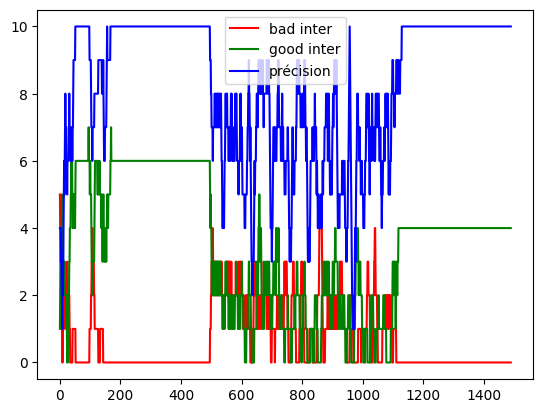

In [ ]:
# Function to map integers to colors
def int_to_color(value):
    if value == 0:
        return "yellow"
    return "gray"

# Create a figure and axis
fig, ax = plt.subplots()

#1 / (len(by_10_bad_inter) -10)
for i, value in enumerate(agent.predictExplor):
    ax.add_patch(plt.Rectangle((i, -10), 0.1, 10, color=int_to_color(value), alpha=0.4))

# Plot the data
plt.plot(by_10_bad_inter, label='bad inter', color='red')
plt.plot(by_10_good_inter, label='good inter', color='green')
plt.plot(pourcent_by_10, label='précision', color='blue')
# Transparent
# plt.plot(mean_val, label='mean valence', color='black')

plt.legend()
plt.show()
plt.close()



In [ ]:
# Function to map integers to colors
def int_to_color(value):
    if value == 0:
        return "yellow"
    return "gray"

# Create a figure and axis
fig, ax = plt.subplots()

#1 / (len(by_10_bad_inter) -10)
for i, value in enumerate(agent.predictExplor):
    ax.add_patch(plt.Rectangle((i, -10), 0.1, 10, color=int_to_color(value), alpha=0.4))

# Plot the data
plt.plot(by_100_bad_inter, label='bad inter', color='red')
plt.plot(by_100_good_inter, label='good inter', color='green')
# plt.plot(pourcent_by_10, label='précision', color='blue')
# Transparent
# plt.plot(mean_val, label='mean valence', color='black')

plt.legend()
plt.show()
plt.close()
